In [1]:
import findspark
findspark.init()

import pyspark
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("fifa19_analysis").getOrCreate()
spark

In [2]:
from pyspark.sql.functions import *
from pyspark.sql.types import *
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# Seaborn settings
sns.set_style("whitegrid")

In [3]:
fifa = spark.read.csv('data/fifa19.csv', inferSchema=True, header=True)

In [4]:
fifa.limit(5).toPandas()

,_c0,ID,Name,Age,Photo,Nationality,Flag,Overall,Potential,Club,...,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes,Release Clause
0,0,158023,L. Messi,31,https://cdn.sofifa.org/players/4/19/158023.png,Argentina,https://cdn.sofifa.org/flags/52.png,94,94,FC Barcelona,...,96,33,28,26,6,11,15,14,8,€226.5M
1,1,20801,Cristiano Ronaldo,33,https://cdn.sofifa.org/players/4/19/20801.png,Portugal,https://cdn.sofifa.org/flags/38.png,94,94,Juventus,...,95,28,31,23,7,11,15,14,11,€127.1M
2,2,190871,Neymar Jr,26,https://cdn.sofifa.org/players/4/19/190871.png,Brazil,https://cdn.sofifa.org/flags/54.png,92,93,Paris Saint-Germain,...,94,27,24,33,9,9,15,15,11,€228.1M
3,3,193080,De Gea,27,https://cdn.sofifa.org/players/4/19/193080.png,Spain,https://cdn.sofifa.org/flags/45.png,91,93,Manchester United,...,68,15,21,13,90,85,87,88,94,€138.6M
4,4,192985,K. De Bruyne,27,https://cdn.sofifa.org/players/4/19/192985.png,Belgium,https://cdn.sofifa.org/flags/7.png,91,92,Manchester City,...,88,68,58,51,15,13,5,10,13,€196.4M


In [5]:
fifa.printSchema

<bound method DataFrame.printSchema of DataFrame[_c0: int, ID: int, Name: string, Age: int, Photo: string, Nationality: string, Flag: string, Overall: int, Potential: int, Club: string, Club Logo: string, Value: string, Wage: string, Special: int, Preferred Foot: string, International Reputation: int, Weak Foot: int, Skill Moves: int, Work Rate: string, Body Type: string, Real Face: string, Position: string, Jersey Number: int, Joined: string, Loaned From: string, Contract Valid Until: string, Height: string, Weight: string, LS: string, ST: string, RS: string, LW: string, LF: string, CF: string, RF: string, RW: string, LAM: string, CAM: string, RAM: string, LM: string, LCM: string, CM: string, RCM: string, RM: string, LWB: string, LDM: string, CDM: string, RDM: string, RWB: string, LB: string, LCB: string, CB: string, RCB: string, RB: string, Crossing: int, Finishing: int, HeadingAccuracy: int, ShortPassing: int, Volleys: int, Dribbling: int, Curve: int, FKAccuracy: int, LongPassing: i

In [6]:
fifa.createOrReplaceTempView('fifaView')

### How many players are there in each position?

In [7]:
df1 = spark.sql("SELECT Position, count(*) AS Count FROM fifaView GROUP BY Position ORDER BY Count DESC")
df1.toPandas()

,Position,Count
0,ST,2152
1,GK,2025
2,CB,1778
3,CM,1394
4,LB,1322
5,RB,1291
6,RM,1124
7,LM,1095
8,CAM,958
9,CDM,948


In [8]:
# Remove position column which has null value
df1_filtered = df1.filter("Position is not null")
df1_pd = df1_filtered.toPandas()

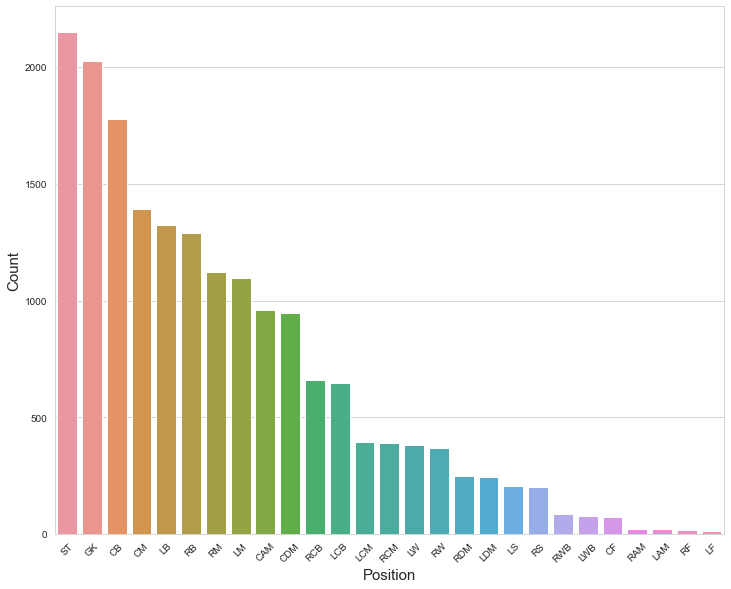

In [9]:
plt.figure(figsize=(10,8))
plt.xticks(rotation=45)
plt.tight_layout()
plt.xlabel('Position', fontsize=15)
plt.ylabel('Count', fontsize=15)

sns.barplot(x='Position', y='Count', data=df1_pd)
plt.savefig("Number of players for each position.png")

### How many players are participating from each country? (300 and over)

In [10]:
df2 = spark.sql("SELECT Nationality, count(*) AS Count FROM fifaView GROUP BY Nationality ORDER BY Count DESC")
df2.toPandas().head()

,Nationality,Count
0,England,1662
1,Germany,1198
2,Spain,1072
3,Argentina,937
4,France,914


In [11]:
# Get those which have two hundreds and over
df2_over_50 = df2.where("Count > 300")
df2_pd = df2_over_50.toPandas()
df2_pd

,Nationality,Count
0,England,1662
1,Germany,1198
2,Spain,1072
3,Argentina,937
4,France,914
5,Brazil,827
6,Italy,702
7,Colombia,618
8,Japan,478
9,Netherlands,453


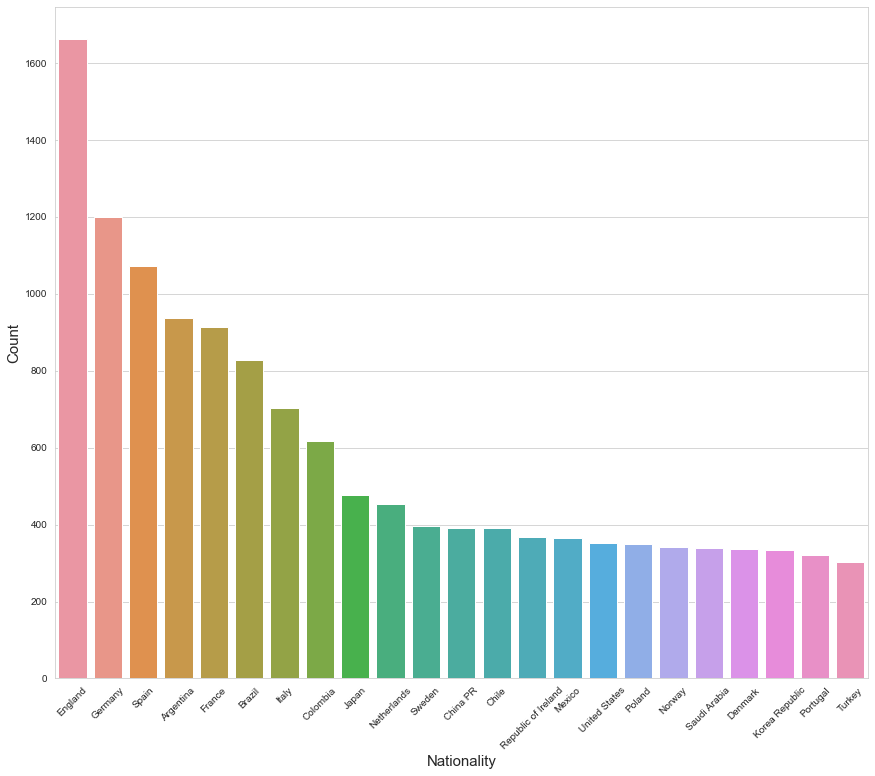

In [12]:
plt.figure(figsize=(12,10))
plt.xticks(rotation=45)
plt.tight_layout()
plt.xlabel('Nationality', fontsize=15)
plt.ylabel('Count', fontsize=15)

sns.barplot(x='Nationality', y='Count', data=df2_pd)
plt.savefig("Number of players for each country.png")

### How much overall point and wage are related? (Top 500 players based on Wage)

In [13]:
# Data cleaning
df3 = fifa.select('Name', 'Overall', translate(col('Wage'), '€K', "").alias('Wage'))

In [14]:
df3_casted = df3.withColumn("Wage", df3.Wage.cast(IntegerType()))

In [15]:
df3_casted.printSchema()

root
 |-- Name: string (nullable = true)
 |-- Overall: integer (nullable = true)
 |-- Wage: integer (nullable = true)



In [16]:
# get top 500 players based on Wage
df3_ordered = df3_casted.orderBy(col('Wage').desc())

In [17]:
df3_pd = df3_ordered.limit(500).toPandas()
df3_pd

,Name,Overall,Wage
0,L. Messi,94,565
1,L. Suárez,91,455
2,L. Modrić,91,420
3,Cristiano Ronaldo,94,405
4,Sergio Ramos,91,380
...,...,...,...
495,J. Stanislas,75,55
496,Douglas Luiz,73,55
497,A. Kramarić,82,54
498,L. Bailey,81,54


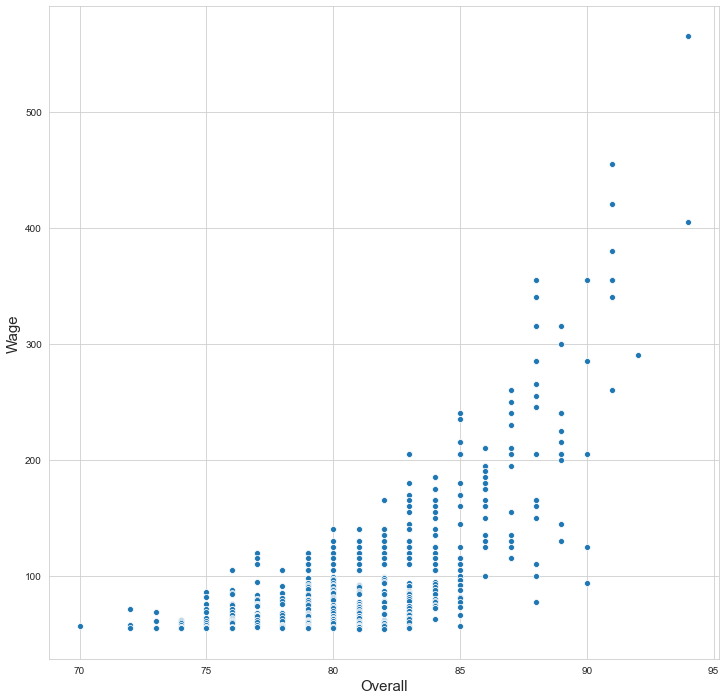

In [20]:
plt.figure(figsize=(12,12))
plt.tight_layout()
plt.xlabel('Overall', fontsize=15)
plt.ylabel('Wage', fontsize=15)

sns.scatterplot(x='Overall', y='Wage', data=df3_pd)
plt.savefig("Scatter plot for Overall and Wage.png")